In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as stats
from scipy.optimize import minimize

%matplotlib inline

# Gradient descent

In [94]:
def gradient_descent(prev_guess, step, derivative_f):
    '''
    Given a previous_guess, the step size and the value of the derivative_f
    this function outputs a new guess
    '''
    new_guess = prev_guess - step*derivative_f
    return new_guess

In [95]:
# use gradient descent to optimize the previous functions
# Provide analytic derivative (instead of numerical derivative: this usually speeds up gradient-based algorithms)
def quadratic_fn(x):
    y = np.power(x,2)
    return y

def quadratic_derivative(x):
    dy = 2*x
    return dy

In [96]:
# two parameters we need to initialize
x_init = -10
step=0.2
# other parameters to stop the algorithm
max_iter = 1000
stopping_criterion = 0.0001
curr_diff = 100
counter = 0
while curr_diff>stopping_criterion and counter<max_iter:
    # Update guess
    x_new = gradient_descent(x_init, step, quadratic_derivative(x_init))
    # update difference, initial and counter
    curr_diff = np.abs(x_new-x_init)
    x_init = x_new
    counter +=1

print('Optimal x is {0}'.format(x_new))


Optimal x is -0.00013162170384226703


[-11, 1, -1, 115]

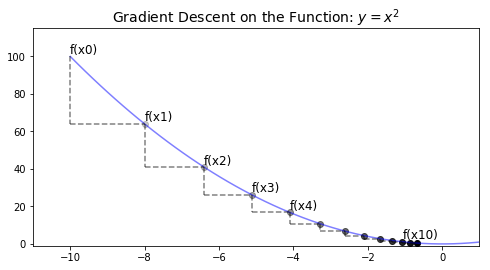

In [97]:
# Plot results
x = np.linspace(-10,10,100)
y = quadratic_fn(x)
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x,y, color='b', alpha=0.5)
ax.axis([-10,10,-5,100])
ymin, ymax = ax.get_xlim()
# ready to initialize gradient descent
x_init = -10
max_iter = 12
step=0.1
for k in range(max_iter):
    # find derivative:
    curr_guess = gradient_descent(x_init, step, quadratic_derivative(x_init))
    ax.scatter(curr_guess, quadratic_fn(curr_guess), color='k', alpha=np.linspace(0.2,1,max_iter)[k])
    # get some arrows
    ax.plot([x_init,x_init],[quadratic_fn(x_init),quadratic_fn(curr_guess)], ls='--', color='k', alpha=0.5)
    ax.plot([x_init,curr_guess],[quadratic_fn(curr_guess),quadratic_fn(curr_guess)], ls='--', color='k', alpha=0.5)
    # get text: for readability I will only plot some of these texts
    if k<5 or k==10:
        x_string = 'f(x'+str(k)+')'
        ax.text(x_init, quadratic_fn(x_init), x_string, verticalalignment='bottom', horizontalalignment='left',
               fontsize=12)
    # update initial
    x_init = curr_guess
ax.set_title('Gradient Descent on the Function: $y=x^2$', fontsize=14)
ax.axis([-11,1,-1,115])


# Capex investment

* Revenues in each city ($c$) are: $R_c=P_c\times Q_c \times (1+g_c(x_c))$
* Total revenues the sum of all revenues: $\text{Total Revenue} = R_1 + R_2$

In [98]:
def logistic_growth(x, A,K,C,D,B,nu):
    '''
    Generalized logistic function
    '''
    return A + (K-A)/(C + D*np.exp(-B*x))**(1/nu)

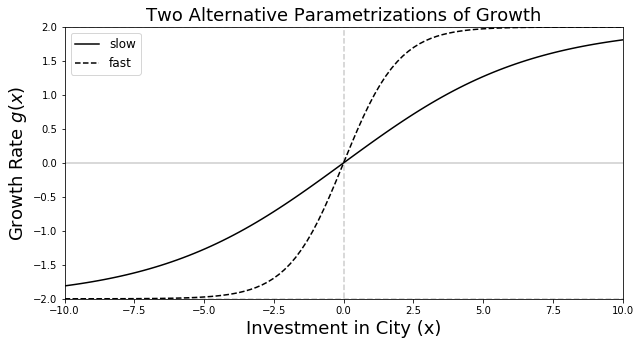

In [99]:
# plot to get an idea
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(-10,10,100)
y1 = logistic_growth(x, A=-2,K=2, C=1, D=1, B=0.3, nu=1)
ax.plot(x,y1, color='k', label='slow')
y2 = logistic_growth(x, A=-2,K=2, C=1, D=1, B=1, nu=1)
ax.plot(x,y2, color='k', label='fast', ls='--')
ax.plot([-10,10],[0,0], color='k', alpha=0.2)
ax.plot([-10,10],[2,2], color='k', alpha=0.2, ls='--')
ax.plot([-10,10],[-2,-2], color='k', alpha=0.2, ls='--')
ax.plot([0,0],[-2.1,2.1], color='k', alpha=0.2, ls='--')
ax.axis([-10,10,-2,2])
ax.set_title('Two Alternative Parametrizations of Growth', fontsize=18)
ax.set_xlabel('Investment in City (x)', fontsize=18)
ax.set_ylabel('Growth Rate $g(x)$', fontsize=18)
ax.legend(loc=2, fontsize=12)

In [100]:
def revenues_in_city(x,**kwargs):
    '''
    Compute revenues as a function of investment (x)
    Note: keyword arguments (**kwargs) allow us to parametrize growth (A,K,C,Q,B,nu) and price, sales
    '''
    P,Q,A,K,C,D,B,nu = kwargs['P'],kwargs['Q'],kwargs['A'],kwargs['K'],kwargs['C'],kwargs['D'],kwargs['B'],kwargs['nu']
    revenues = P*Q*(1+logistic_growth(x, A,K,C,D,B,nu))
    return revenues

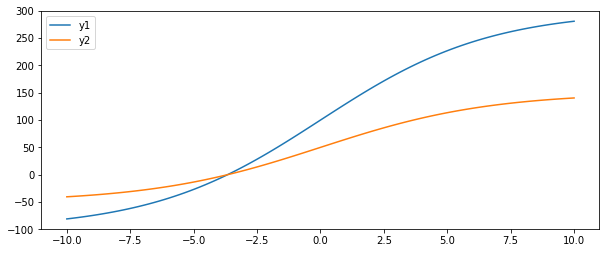

In [101]:
# Let's check how revenues in each city look
# Pass some prices and sales for two cities
p1 = 1
p2 = 1
q1 = 100 # note that city 1 is twice as large in terms of sales (volume)
q2 = 50
# now growth rates
A = -2
K = 2
C = 1
D = 1
B = 0.3
nu = 1
# try our function
rev1 = revenues_in_city(x,P=p1, Q=q1, A=A, K=K, C=C, D=D, B=B, nu=nu)
rev2 = revenues_in_city(x,P=p2, Q=q2, A=A, K=K, C=C, D=D, B=B, nu=nu)
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(x,rev1, label='y1')
ax.plot(x, rev2, label='y2')
ax.legend()


In [102]:
def total_revenues(x,**kwargs):
    '''
    In the case of two cities, and total budget of CAPEX that must be exhausted, 
    our problem can be reduced to one variable 
    '''
    A,K,C,D,B,nu = kwargs['A'],kwargs['K'],kwargs['C'],kwargs['D'],kwargs['B'],kwargs['nu']
    P1,Q1 = kwargs['P1'],kwargs['Q1']
    P2,Q2 = kwargs['P2'],kwargs['Q2']
    CAPEX = kwargs['CAPEX']
    rev1 = P1*Q1*(1+logistic_growth(x, A,K,C,D,B,nu))
    rev2 = P2*Q2*(1+logistic_growth(CAPEX-x, A,K,C,D,B,nu))
    total_rev = rev1 + rev2
    return total_rev

In [103]:
# use our iterative algorithm of assigning $1 dollar where incremental revenues are highest
def find_the_optimum_iteratively(CAPEX, **kwargs):
    '''
    We can assign one dollar to the city with largest incremental (marginal) revenue
    '''
    # to allow for asymmetric cases we can include some parameters
    p1,q1 = kwargs['P1'],kwargs['Q1']
    p2,q2 = kwargs['P2'],kwargs['Q2']
    B = kwargs['B']
    # Initialize array to save incremental allocations
    optimal_assignments = np.zeros((CAPEX,2))
    # I can assign at most CAPEX $1 dollars, iteration finishes then
    for x in range(CAPEX):
        # compute revenues for both cities if we assigned the marginal dollar
        # 1. Accumulate previous investments (if any)
        x_init1, x_init2 = np.sum(optimal_assignments[:x,:], axis=0)
        # Test allocations: current allocations plus an additional $1
        x_test1, x_test2 = x_init1+1, x_init2+1
        # Compute Marginal Revenues: rev(x+1)-rev(x)
        marg_rev1_x = (revenues_in_city(x_test1,P=p1, Q=q1, A=A, K=K, C=C, D=D, B=B, nu=nu)-
                          revenues_in_city(x_init1,P=p1, Q=q1, A=A, K=K, C=C, D=D, B=B, nu=nu))
        marg_rev2_x = (revenues_in_city(x_test2,P=p2, Q=q2, A=A, K=K, C=C, D=D, B=B, nu=nu)-
                          revenues_in_city(x_init2,P=p2, Q=q2, A=A, K=K, C=C, D=D, B=B, nu=nu))
        #print('Iteration ={0}, rev1 = {1}, rev2={2}'.format(x, marg_rev1_x, marg_rev2_x))
        # if they are the same, it doesn't matter where you assign it
        if marg_rev1_x==marg_rev2_x:
            optimal_assignments[x,0] = 1
        elif marg_rev1_x>marg_rev2_x:
            optimal_assignments[x,0] = 1
        elif marg_rev1_x<marg_rev2_x:
            optimal_assignments[x,1] = 1
    # when done, we get the full trayectory of investments
    return optimal_assignments
            
            

# Symmetric case:

* If we have two identical cities, we should expect that out of CAPEX=100, 50 are allocated to each city
* We saw that when the objective function was plotted
* And economic intuition suggests the same
* So if algorithm is working we should have this outcome

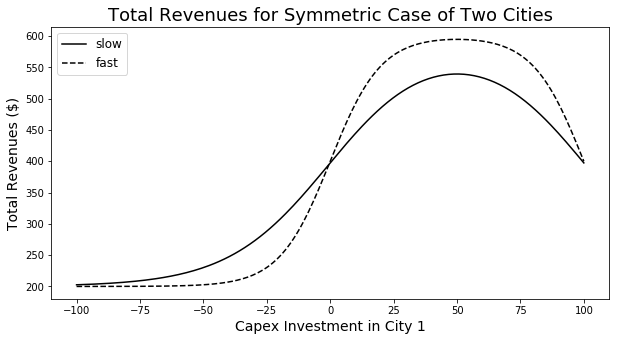

In [104]:
xgrid = np.linspace(-100,100,200)
# symmetric case: two cities that are the same
p1 = 1
p2 = 1
q1 = 100
q2 = 100
# Total revenues for the case of slow growth (B=0.05)
total_revenues_symmetric_05 = total_revenues(xgrid,P1=p1, Q1=q1, P2=p2, Q2=q2, CAPEX=100, 
                                          A=A, K=K, C=C, D=D, B=0.05, nu=nu)

# Total revenues for the case of faster growth (B=0.1)
total_revenues_symmetric_1 = total_revenues(xgrid,P1=p1, Q1=q1, P2=p2, Q2=q2, CAPEX=100, 
                                          A=A, K=K, C=C, D=D, B=0.1, nu=nu)

# ready to plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xgrid, total_revenues_symmetric_05, color='k',label='slow')
ax.plot(xgrid, total_revenues_symmetric_1, color='k', ls='--', label='fast')
ax.set_title('Total Revenues for Symmetric Case of Two Cities', fontsize=18)
ax.set_xlabel('Capex Investment in City 1', fontsize=14)
ax.set_ylabel('Total Revenues ($)', fontsize=14)
ax.legend(loc=2, fontsize=12)

Text(0, 0.5, '$   ')

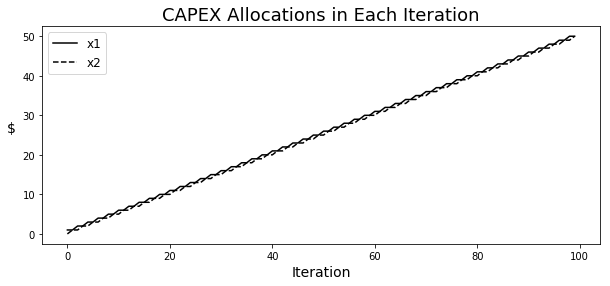

In [105]:
# test with symmetric_case
allocations_symmetric = pd.DataFrame(find_the_optimum_iteratively(CAPEX=100, P1=1, P2=1, Q1=1, Q2=1, B=0.5), 
                                     index=np.arange(100), 
                                    columns=['x1','x2'])
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(np.arange(100), allocations_symmetric.x1.cumsum(), label='x1', color='k')
ax.plot(np.arange(100), allocations_symmetric.x2.cumsum(), label='x2', color='k', ls='--')
ax.legend(loc=2, fontsize=12)
ax.set_title('CAPEX Allocations in Each Iteration', fontsize=18)
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('$   ', fontsize=14, rotation=0)

# Asymmetric Case:
* If one city has a higher ticket ($P_i$) or larger volume ($Q_i$) the marginal revenue of allocating the extra dollar will be higher

* Unless decreasing returns (logistic growth function) kick in

* So we should expected allocation to be biased to the larger city (but not completely thanks to second effect)

Text(0, 0.5, 'Total Revenues ($)')

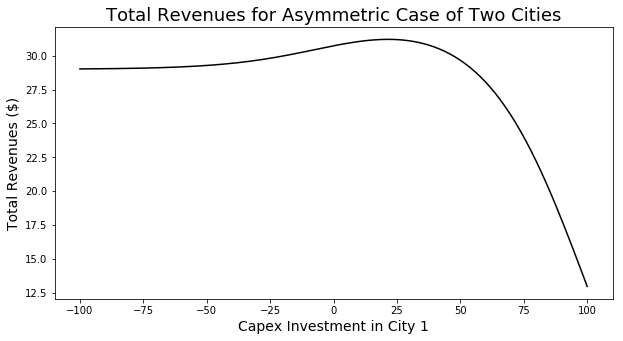

In [106]:
xgrid = np.linspace(-100,100,200)
# asymmetric case: two cities that are the same
p1 = 1
p2 = 1
q1 = 1
q2 = 10 # note that city 2 is 10x larger than city 1 in terms of volume

total_revenues_asym = total_revenues(xgrid,P1=p1, Q1=q1, P2=p2, Q2=q2, CAPEX=100, 
                                          A=A, K=K, C=C, D=D, B=0.05, nu=nu)

# ready to plot
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xgrid, total_revenues_asym, color='k')
ax.set_title('Total Revenues for Asymmetric Case of Two Cities', fontsize=18)
ax.set_xlabel('Capex Investment in City 1', fontsize=14)
ax.set_ylabel('Total Revenues ($)', fontsize=14)

Text(0, 0.5, '$   ')

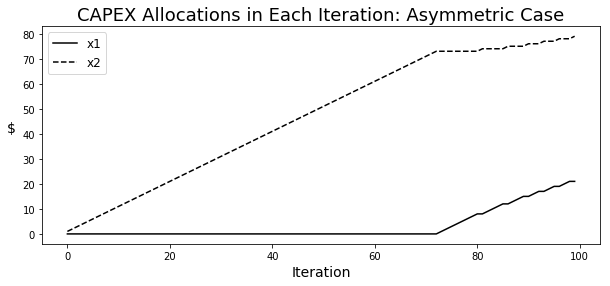

In [107]:
# now with asymmetric
allocations_asymmetric = pd.DataFrame(find_the_optimum_iteratively(CAPEX=100, P1=1, P2=1, Q1=1, Q2=10,B=0.05), 
                                     index=np.arange(100), 
                                    columns=['x1','x2'])
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(np.arange(100), allocations_asymmetric.x1.cumsum(), label='x1', color='k')
ax.plot(np.arange(100), allocations_asymmetric.x2.cumsum(), label='x2', color='k', ls='--')
ax.legend(loc=2, fontsize=12)
ax.set_title('CAPEX Allocations in Each Iteration: Asymmetric Case', fontsize=18)
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('$   ', fontsize=14, rotation=0)

## Before moving on, let's see why numerical optimization is hard

* We will be using some functions from [Scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html)
* Note that these are used for _minimization_: we will convert our objective function by multiplying by -1
* Some of these [functions](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) allow for constraints, but I will let you play with them.
* I will use a different trick: include a penalty in the objective function so that when the constraint is not satisfied the objective function increases (recall that we will be minimizing).

### Start with a simple example to show how this works in Python

In [108]:
# start with a simple example the we know how to work with: y=x^2
# since our objective needs to be parametrized, I'll work with y=ax^2 to show how this works
# try this with something that I understand first: x^2
# Note that we know that the optimal x* = 0
# I'm using BFGS.  Refer to documentation to see alternatives.

def quadratic_fn(x,**kwargs):
    '''
    Objective function
    '''
    a = kwargs['a']
    y = a*np.power(x,2)
    return y

def quadratic_derivative(x,**kwargs):
    '''
    Derivative-based methods reach an optimum faster if we provide the gradient
    '''
    a = kwargs['a']
    dy = 2*a*x
    return dy

def func_wrapper(x):
    '''
    We need to wrap this function, since `minimize` needs a function that depends
    only on our decision variable
    '''
    a = 10
    return quadratic_fn(x,a=a)

def derivative_wrapper(x):
    '''
    wrapper for derivative
    '''
    a=10
    return quadratic_derivative(x,a=a)

x0 = -10
res = minimize(func_wrapper, x0, method='BFGS', jac= derivative_wrapper,tol=1e-6)
print('Full results = {0}'.format(res))
print('--------------------------------------------')
print('Find the optimal x = {0}'.format(res['x']))

Full results =       fun: 0.0
 hess_inv: array([[0.05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([0.])
--------------------------------------------
Find the optimal x = [0.]


### Move to our actual problem

In [109]:
def total_revenues_twovars_penalty(x,**kwargs):
    '''
    Example with numerical optimization.  
    I include a penalty here
    x: array 
    '''
    size_penalty = kwargs['penalty']
    x1,x2 = x
    A,K,C,D,B,nu = kwargs['A'],kwargs['K'],kwargs['C'],kwargs['D'],kwargs['B'],kwargs['nu']
    P1,Q1 = kwargs['P1'],kwargs['Q1']
    P2,Q2 = kwargs['P2'],kwargs['Q2']
    CAPEX = kwargs['CAPEX']
    rev1 = P1*Q1*(1+logistic_growth(x1, A,K,C,D,B,nu))
    rev2 = P2*Q2*(1+logistic_growth(x2, A,K,C,D,B,nu))
    total_rev = rev1 + rev2
    # to include penalty I need the restriction: note I'm using absolute value here
    restriction = np.abs(CAPEX-x1-x2)
    total_rev_penalty = total_rev - size_penalty*restriction*total_rev
    # finally since I want to minimize change signs
    total_rev_penalty *=-1
    return total_rev_penalty

def objective_wrapper_penalty(x):
    '''
    wrapper for numerical optimization
    '''
    # Parameters for logistic growth
    A,K,C,D,B,nu = [-2,2,1,1,0.05,1]
    penalty = 0.01
    # revenue parameters
    CAPEX,P1,P2,Q1,Q2 = [100,1,1,1,1]
    objective = total_revenues_twovars_penalty(x,A=A,K=K,C=C,D=D,B=B,nu=nu,
                                                   CAPEX=CAPEX,P1=P1,P2=P2,Q1=Q1,Q2=Q2,
                                              penalty=penalty)

    return objective

-5.393134559830052


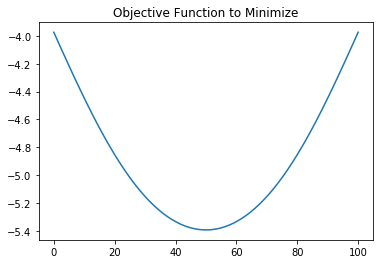

In [110]:
# test, it's always good to test!
# plot first
# let's see how this looks
N = 101
x1 = np.arange(-10000,1000,1)
x1 = np.arange(N)
x2 = 100-x1
func_array = np.zeros(len(x1))
for k in range(N):
    x = [x1[k],x2[k]]
    fn_k = objective_wrapper_penalty(x)
    func_array[k] = fn_k
    
plt.plot(x1,func_array)
plt.title('Objective Function to Minimize')
# evaluate on optimum
x = [50,50]
check_obj = objective_wrapper_penalty(x)
print(check_obj)

In [111]:
# Initialize at 0 both cities and run
# Note I'm not passing the gradient
# And yes, it works (but it took a while to make it work, believe me... numerical optimization is hard!)
x0 = [0,0]
res_00 = minimize(objective_wrapper_penalty, x0, method='BFGS', jac= None,tol=1e-6)
print(res_00)

      fun: -5.393134559545206
 hess_inv: array([[846.02096863, 845.02096863],
       [845.02096863, 846.02096863]])
      jac: array([0.00956756, 0.00956756])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 508
      nit: 1
     njev: 124
   status: 2
  success: False
        x: array([50., 50.])


In [112]:
# Nelder-Mead is not derivative based, but many times it works better!  I always try it but if 
# I can take derivatives and provide the gradient I do so
x0 = [0,0]
res = minimize(objective_wrapper_penalty, x0, method='Nelder-Mead')
res


 final_simplex: (array([[50.00002821, 49.99997179],
       [49.99993137, 50.00006863],
       [49.9999587 , 50.0000413 ]]), array([-5.39313456, -5.39313456, -5.39313456]))
           fun: -5.3931345598260405
       message: 'Optimization terminated successfully.'
          nfev: 276
           nit: 145
        status: 0
       success: True
             x: array([50.00002821, 49.99997179])

#### In the previous example I cheated: 
* I included the penalty myself, instead of using the algorithms that allow for linear constraints
* But calibrating how much to penalize is done by trial and error: **you really need to know your objective when doing numerical optimization**
* Let me show you how things aren't that nice if you don't do that work

In [113]:
def objective_wrapper_penalty_v1(x):
    '''
    Change size of penalty from 0.01 to 0.5
    '''
    # Parameters for logistic growth
    A,K,C,D,B,nu = [-2,2,1,1,0.05,1]
    penalty = 0.5
    # revenue parameters
    CAPEX,P1,P2,Q1,Q2 = [100,1,1,1,1]
    objective = total_revenues_twovars_penalty(x,A=A,K=K,C=C,D=D,B=B,nu=nu,
                                                   CAPEX=CAPEX,P1=P1,P2=P2,Q1=Q1,Q2=Q2, penalty=penalty)

    return objective

In [114]:
# BFGS: note how this fails miserably: result suggests we disinvest A LOT in BOTH cities
# (at last it respects the symmetry :)
x0 = [0,0]
res_00 = minimize(objective_wrapper_penalty_v1, x0, method='BFGS', jac= None,tol=1e-6)
print('Full results from BFGS = {0}'.format(res_00))
print('Optimal investment in both cities = {0}'.format(res_00['x']))

Full results from BFGS =       fun: -1095102811.1712253
 hess_inv: array([[194.88697869, 193.88697869],
       [193.88697869, 194.88697869]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 2
     njev: 17
   status: 0
  success: True
        x: array([-5.47551357e+08, -5.47551357e+08])
Optimal investment in both cities = [-5.47551357e+08 -5.47551357e+08]


In [115]:
# Oops, Nelder-Mead couldn't handle with this choice of initialization parameter (you can play with others)
x0 = [0,0]
res = minimize(objective_wrapper_penalty_v1, x0, method='Nelder-Mead')
print('Full results from Nelder-Meade = {0}'.format(res))
print('Optimal investment in both cities = {0}'.format(res['x']))

Full results from Nelder-Meade =  final_simplex: (array([[-3.52837564e+40, -3.52835717e+40],
       [-2.09257491e+40, -2.09256395e+40],
       [-1.24104409e+40, -1.24103760e+40]]), array([-7.05673280e+40, -4.18513886e+40, -2.48208169e+40]))
           fun: -7.056732803183838e+40
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 400
           nit: 209
        status: 1
       success: False
             x: array([-3.52837564e+40, -3.52835717e+40])
Optimal investment in both cities = [-3.52837564e+40 -3.52835717e+40]


Text(0.5, 1.0, 'Objective function in the range')

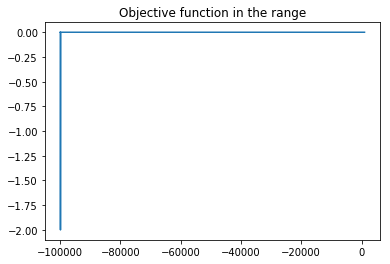

In [116]:
# plot objective function to see why it fails
# After analyzing this I knew I had to change the size of the penalty.  But it took a while
x1 = np.arange(-1e5,1000,1)
x2 = 100-x1
func_array = np.zeros(len(x1))
for x in zip(x1,x2):
    fn_k = objective_wrapper_penalty(x)
    func_array[k] = fn_k

plt.plot(x1,func_array)
plt.title('Objective function in the range')

# Optimal staffing: queueing theory

* Here we simulate the problem _without_ uncertainty 
* **Key parameters**: entry/arrival ($\lambda$) and exit/service ($\mu$) rates

In [117]:
def compute_waiting_time_deterministic(entry_rate, service_rate, n_cashiers):
    '''
    Given entry_rate, service_rate, n_cashiers
    Simulate waiting time in a deterministic setting
    '''
    # Get a DF to compute average waiting time 
    # in the deterministic optimal staffing problem
    n = n_cashiers
    time_per_customer = 1/service_rate
    # save results in a DF:
    # rows: groups of n customers served at a time
    number_of_rows = int(np.ceil(entry_rate/n))
    df_simu = pd.DataFrame(n*np.ones((number_of_rows, 1)), columns=['customers'])
    # check that total customers in line match the entry_rate
    cum_sum = df_simu.customers.cumsum()
    diff = df_simu.customers.sum()-entry_rate
    df_simu.customers.loc[cum_sum>entry_rate] -=diff 
    # compute waiting_time per group of n customers served
    df_simu['wait_time'] = df_simu.index*time_per_customer
    # Average will be waited by each group's share
    df_simu['frac_waiting'] = df_simu.customers/entry_rate
    # Share x Waiting Time of each Group
    df_simu['frac_times_time'] = df_simu.frac_waiting*df_simu.wait_time
    # accumulate to find weighted average (last observation will be average waiting time)
    df_simu['cum_avg'] = df_simu.frac_times_time.cumsum()
    # average waiting time
    avgwt = df_simu.cum_avg.iloc[-1]
    return avgwt, df_simu
# test
avgwt, results_df = compute_waiting_time_deterministic(entry_rate=100, service_rate=20, n_cashiers=5)
print('Average Waiting Time (minutes) = {0}'.format(avgwt*60))

Average Waiting Time (minutes) = 28.500000000000004


In [118]:
# create a plot of waiting times
def plot_waiting_times(entry_rate, service_rate, n_cashiers, ax, minutes_per_period):
    a,b = compute_waiting_time_deterministic(entry_rate, service_rate, n_cashiers)
    # ready to plot: start with first n = n_cashiers customers
    n_r = b.shape[0]
    alpha_vec = np.linspace(0.2,0.99,n_r)
    for i,r in enumerate(b.index):
        customers_in_batch = b.customers.iloc[i]
        time_waiting = int(b.wait_time.iloc[i]*minutes_per_period)
        if n_cashiers == customers_in_batch:
            ax.scatter(time_waiting*np.ones((n_cashiers)),np.arange(n_cashiers), s=200, edgecolor='k',
                       facecolor=str(alpha_vec[n_r-i-1]),alpha = 1)
        else:
            ax.scatter(time_waiting*np.ones((int(customers_in_batch))),
                       np.arange(int(customers_in_batch)), s=200, edgecolor='k',
                       facecolor=str(alpha_vec[n_r-i-1]),alpha = 1)
    ax.set_xticks(b.wait_time*minutes_per_period)
    ax.set_xticklabels([int(i) for i in np.round(b.wait_time*minutes_per_period,decimals=1)], fontsize=12)
    ax.set_yticks(np.arange(n_cashiers))
    ax.set_yticklabels(range(1,n_cashiers+1), fontsize=12)
    ax.set_ylabel('Each cashier', fontsize=14)
    ax.set_xlabel('Waiting time (minutes)', fontsize=14)
    # plot mean waiting time
    ymin, ymax = plt.ylim()
    mean_waiting_time = a*minutes_per_period
    ax.plot([mean_waiting_time,mean_waiting_time],[-0.5,n_cashiers-0.5], color='k', ls='--', lw=2)
    ax.plot([minutes_per_period,minutes_per_period],[-0.5,n_cashiers-0.5], color='k', ls='-', alpha=0.5)
    return None

Text(0, 0.5, 'Minutes')

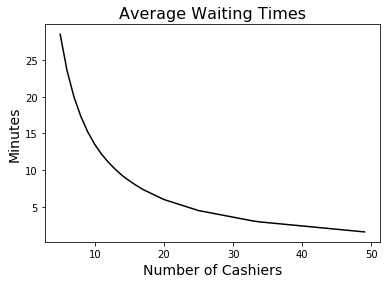

In [119]:
# test function
n_grid = np.arange(5,50)
wait_time = [60*compute_waiting_time_deterministic(entry_rate=100, service_rate=20, n_cashiers=n)[0] for n in n_grid]
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(n_grid, wait_time, color='k')
ax.set_title('Average Waiting Times', fontsize=16)
ax.set_xlabel('Number of Cashiers', fontsize=14)
ax.set_ylabel('Minutes', fontsize=14)

# Monte Carlo simulations

In [120]:
def quadratic_stoch(x,epsilon):
    '''
    y = \epsilon * x^2
    I will make epsilon random so that depending on the realization function can actually 
    be convex or concave
    '''
    return epsilon*x**2

Simulated Probability of Convex = 4.575%
Exact Probability of Convex = 4.78%


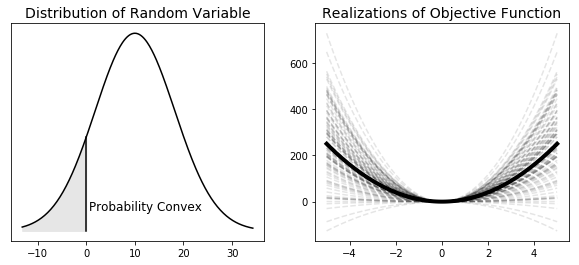

In [121]:
# say epsilon~ N(10,6^2)
# simulate 100 realizations
np.random.seed(11619)
K = 100
eps_simu = 10 + 6*np.random.randn(K,1)
x_grid = np.linspace(-5,5,100)
fig, ax = plt.subplots(1,2,figsize=(10,4))
# Left panel: just a normal density
nobs=20000
norm = 10 + 6*np.random.randn(nobs)
density = gaussian_kde(norm)
xs = np.linspace(norm.min(), norm.max(),300)
density.covariance_factor = lambda : 0.95
density._compute_covariance()
ax[0].plot(xs, density(xs), color='k')
ax[0].fill_between(xs,density(xs),where=xs<0, color='0.9')
ax[0].plot([0,0],[0,density(0)], color='k')
ax[0].set_yticks([])
ax[0].text(0.5,0.005,'Probability Convex', fontsize=12)
# Right panel: 100 realizations of the objective function and the expectation
ax[1].plot(x_grid, quadratic_stoch(x_grid,10), color='k', lw=4)
for k in range(K):
    y_k = quadratic_stoch(x_grid,eps_simu[k])
    ax[1].plot(x_grid, y_k, color='k', alpha=0.1, ls='--')
ax[0].set_title('Distribution of Random Variable', fontsize=14)
ax[1].set_title('Realizations of Objective Function', fontsize=14)
print('Simulated Probability of Convex = {0}%'.format(100*np.mean(norm<0)))
print('Exact Probability of Convex = {0}%'.format(np.around(100*stats.norm.cdf(-10/6),decimals=2)))

In [122]:
# Monte Carlo simulation
def get_montecarlo_simulation(objective_func,grid_x, N_draws):
    '''
    For each realization we will have (x_k,objective_func(x_k,realization))
    We then average _across_ realizations
    Inputs:
    objective_function: pointer to a well-defined Python Function that takes an array (grid_x) and returns
                        an array of the same size
    grid_x: the grid over our decision variable where we wish to evaluate the function
    N_draws: size of our Monte Carlo Simulation
    Output:
    An array of length, len(grid_x) of sample averages across draws
    '''
    # get random draws: in this case we know it's Normal N(10,36)
    draws_from_normal = 10 + 6*np.random.randn(N_draws,1)
    # Initialize matrix to store results
    K = len(grid_x)
    matrix_results = np.zeros((K,N_draws))
    for i,draw in enumerate(draws_from_normal):
        eval_i = objective_func(x=grid_x,epsilon=draw)
        # save in corresponding row
        matrix_results[:,i] = eval_i
    # Find sample average:
    sample_avg =  np.mean(matrix_results,axis=1)
    return sample_avg

Text(0.5, 1.0, 'Objective Function With Monte Carlo Simulation')

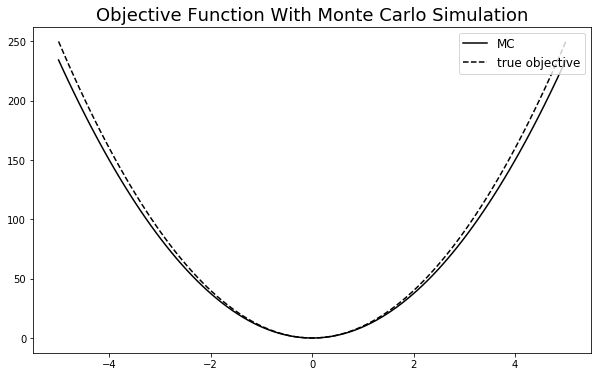

In [123]:
np.random.seed(100)
objective_montecarlo = get_montecarlo_simulation(quadratic_stoch,grid_x=x_grid,N_draws=100)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_grid,objective_montecarlo, color='k', label='MC')
ax.plot(x_grid,quadratic_stoch(x_grid,10), color='k', label='true objective', ls='--')
ax.legend(loc=1, fontsize=12)
ax.set_title('Objective Function With Monte Carlo Simulation', fontsize=18)